# Operating on Data in Pandas

One of the essential pieces of NumPy is the ability to perform quick element-wise operations, both with basic arithmetic (addition, subtraction, multiplication, etc.) and with more sophisticated operations (trigonometric functions, exponential and logarithmic functions, etc.).
Pandas inherits much of this functionality from NumPy, and the ufuncs that we introduced in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) are key to this.

Pandas includes a couple useful twists, however: for unary operations like negation and trigonometric functions, these ufuncs will *preserve index and column labels* in the output, and for binary operations such as addition and multiplication, Pandas will automatically *align indices* when passing the objects to the ufunc.
This means that keeping the context of data and combining data from different sources–both potentially error-prone tasks with raw NumPy arrays–become essentially foolproof ones with Pandas.
We will additionally see that there are well-defined operations between one-dimensional ``Series`` structures and two-dimensional ``DataFrame`` structures.

## Ufuncs: Index Preservation

Because Pandas is designed to work with NumPy, any NumPy ufunc will work on Pandas ``Series`` and ``DataFrame`` objects.
Let's start by defining a simple ``Series`` and ``DataFrame`` on which to demonstrate this:

In [15]:
import pandas as pd
import numpy as np

In [16]:
rng = np.random.RandomState()
ser = pd.Series(rng.randint(0, 10, 7))
print(ser)

0    9
1    8
2    1
3    2
4    4
5    2
6    7
dtype: int32


In [17]:
ser[0] # indexing

9

In [18]:
ser[0:5] # Slice

0    9
1    8
2    1
3    2
4    4
dtype: int32

In [19]:
ser[0:5:2] # Extendex Slice

0    9
2    1
4    4
dtype: int32

In [20]:
df = pd.DataFrame(rng.randint(0, 10, (5, 5)),
                  columns=['A', 'B', 'C', 'D','E'])

df

,A,B,C,D,E
0,2,9,1,4,6
1,9,7,1,8,5
2,1,7,6,4,7
3,9,4,2,5,8
4,9,1,0,9,8


In [21]:
df['D']

0    4
1    8
2    4
3    5
4    9
Name: D, dtype: int32

In [22]:
df['D'][3]

5

If we apply a NumPy ufunc on either of these objects, the result will be another Pandas object *with the indices preserved:*

In [23]:
a = np.exp(ser)
a

0    8103.083928
1    2980.957987
2       2.718282
3       7.389056
4      54.598150
5       7.389056
6    1096.633158
dtype: float64

([<matplotlib.patches.Wedge at 0x248721964a8>,
 [Text(-0.5339420899448515, 0.9617202527686126, ''),
  Text(0.22625243764188885, -1.0764802991514073, ''),
  Text(0.9087233581575135, -0.6198563207219329, ''),
  Text(0.9103266669238573, -0.6174992789366647, ''),
  Text(0.9200254632044045, -0.6029536856637674, ''),
  Text(0.9294918649056844, -0.5882557888148261, ''),
  Text(1.05680298644136, -0.30523343173483336, '')])

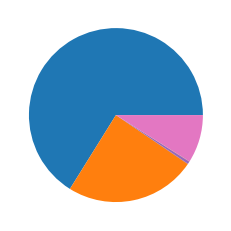

In [24]:
import matplotlib.pyplot as plt
plt.pie(a)

Or, for a slightly more complex calculation:

In [25]:
T=df * np.pi / 4
T

,A,B,C,D,E
0,1.570796,7.068583,0.785398,3.141593,4.712389
1,7.068583,5.497787,0.785398,6.283185,3.926991
2,0.785398,5.497787,4.712389,3.141593,5.497787
3,7.068583,3.141593,1.570796,3.926991,6.283185
4,7.068583,0.785398,0.000000,7.068583,6.283185


In [26]:
np.sin(T)

,A,B,C,D,E
0,1.000000,7.071068e-01,0.707107,1.224647e-16,-1.000000e+00
1,0.707107,-7.071068e-01,0.707107,-2.449294e-16,-7.071068e-01
2,0.707107,-7.071068e-01,-1.000000,1.224647e-16,-7.071068e-01
3,0.707107,1.224647e-16,1.000000,-7.071068e-01,-2.449294e-16
4,0.707107,7.071068e-01,0.000000,7.071068e-01,-2.449294e-16


Any of the ufuncs discussed in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) can be used in a similar manner.

## UFuncs: Index Alignment

For binary operations on two ``Series`` or ``DataFrame`` objects, Pandas will align indices in the process of performing the operation.
This is very convenient when working with incomplete data, as we'll see in some of the examples that follow.

### Index alignment in Series

As an example, suppose we are combining two different data sources, and find only the top three india states by *area* and the top three India states by *population*:

In [27]:
area = pd.Series({'Andhara Pradesh': 1723337, 'Delhi': 695662,
                  'Karnataka': 423967}, name='area')
population = pd.Series({'Andhara Pradesh': 38332521, 'Goa': 26448193,
                        'Karnataka': 19651127}, name='population')
print(area)

Andhara Pradesh    1723337
Delhi               695662
Karnataka           423967
Name: area, dtype: int64


In [28]:
print(population)

Andhara Pradesh    38332521
Goa                26448193
Karnataka          19651127
Name: population, dtype: int64


Let's see what happens when we divide these to compute the population density:

In [29]:
population / area

Andhara Pradesh    22.243195
Delhi                    NaN
Goa                      NaN
Karnataka          46.350605
dtype: float64

The resulting array contains the *union* of indices of the two input arrays, which could be determined using standard Python set arithmetic on these indices:

In [30]:
area.index | population.index

Index(['Andhara Pradesh', 'Delhi', 'Goa', 'Karnataka'], dtype='object')

Any item for which one or the other does not have an entry is marked with ``NaN``, or "Not a Number," which is how Pandas marks missing data (see further discussion of missing data in [Handling Missing Data](03.04-Missing-Values.ipynb)).
This index matching is implemented this way for any of Python's built-in arithmetic expressions; any missing values are filled in with NaN by default:

In [31]:
A = pd.Series([2, 4, 6], index=[0, 1, 2])
B = pd.Series([1, 3, 5], index=[1, 2, 3])

In [32]:
A

0    2
1    4
2    6
dtype: int64

In [33]:
B

1    1
2    3
3    5
dtype: int64

In [34]:
A + B

0    NaN
1    5.0
2    9.0
3    NaN
dtype: float64

If using NaN values is not the desired behavior, the fill value can be modified using appropriate object methods in place of the operators.
For example, calling ``A.add(B)`` is equivalent to calling ``A + B``, but allows optional explicit specification of the fill value for any elements in ``A`` or ``B`` that might be missing:

In [35]:
print(A)
print(B)
A.add(B, fill_value=1)

0    2
1    4
2    6
dtype: int64
1    1
2    3
3    5
dtype: int64


0    3.0
1    5.0
2    9.0
3    6.0
dtype: float64

### Index alignment in DataFrame

A similar type of alignment takes place for *both* columns and indices when performing operations on ``DataFrame``s:

In [36]:
A = pd.DataFrame(rng.randint(0, 20, (5,4)),
                 columns=list('ABCD'))
A

,A,B,C,D
0,6,10,4,17
1,2,15,8,14
2,19,4,8,13
3,2,5,11,9
4,9,17,10,16


In [37]:
B = pd.DataFrame(rng.randint(0, 10, (3, 3)),
                 columns=list('BAC'))
B

,B,A,C
0,7,2,9
1,2,7,7
2,9,7,0


In [38]:
A.mean()

A     7.6
B    10.2
C     8.2
D    13.8
dtype: float64

In [39]:
c = A + B
c

,A,B,C,D
0,8.0,17.0,13.0,NaN
1,9.0,17.0,15.0,NaN
2,26.0,13.0,8.0,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [40]:
c.mean()

A    14.333333
B    15.666667
C    12.000000
D          NaN
dtype: float64

In [41]:
c.describe()

,A,B,C,D
count,3.000000,3.000000,3.000000,0.0
mean,14.333333,15.666667,12.000000,NaN
std,10.115994,2.309401,3.605551,NaN
min,8.000000,13.000000,8.000000,NaN
25%,8.500000,15.000000,10.500000,NaN
50%,9.000000,17.000000,13.000000,NaN
75%,17.500000,17.000000,14.000000,NaN
max,26.000000,17.000000,15.000000,NaN


In [39]:
c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 4 columns):
A    3 non-null float64
B    3 non-null float64
C    3 non-null float64
D    0 non-null float64
dtypes: float64(4)
memory usage: 200.0 bytes


Notice that indices are aligned correctly irrespective of their order in the two objects, and indices in the result are sorted.
As was the case with ``Series``, we can use the associated object's arithmetic method and pass any desired ``fill_value`` to be used in place of missing entries.
Here we'll fill with the mean of all values in ``A`` (computed by first stacking the rows of ``A``):

In [44]:
A.stack()

0  A     6
   B    10
   C     4
   D    17
1  A     2
   B    15
   C     8
   D    14
2  A    19
   B     4
   C     8
   D    13
3  A     2
   B     5
   C    11
   D     9
4  A     9
   B    17
   C    10
   D    16
dtype: int32

In [45]:
fill = A.stack().mean()
fill

9.95

In [48]:
A.add(B, fill_value=fill)

,A,B,C,D
0,8.00,17.00,13.00,26.95
1,9.00,17.00,15.00,23.95
2,26.00,13.00,8.00,22.95
3,11.95,14.95,20.95,18.95
4,18.95,26.95,19.95,25.95


The following table lists Python operators and their equivalent Pandas object methods:

| Python Operator | Pandas Method(s)                      |Numpy Methods(s)|
|-----------------|---------------------------------------|----------------|
| ``+``           | ``add()``                             |``sum()``,``add()``|
| ``-``           | ``sub()``, ``subtract()``             |``subtract()``|
| ``*``           | ``mul()``, ``multiply()``             |``multiply()``
| ``/``           | ``truediv()``, ``div()``, ``divide()``|``divide()``
| ``//``          | ``floordiv()``                        |``floordiv()``
| ``%``           | ``mod()``                             |``mod()``,``divmod()``
| ``**``          | ``pow()``                             |``exp()``


## Ufuncs: Operations Between DataFrame and Series

When performing operations between a ``DataFrame`` and a ``Series``, the index and column alignment is similarly maintained.
Operations between a ``DataFrame`` and a ``Series`` are similar to operations between a two-dimensional and one-dimensional NumPy array.
Consider one common operation, where we find the difference of a two-dimensional array and one of its rows:

In [50]:
A = rng.randint(10, size=(3, 4))
A

array([[1, 8, 9, 2],
       [4, 7, 5, 6],
       [1, 3, 2, 8]])

In [51]:
A[0]

array([1, 8, 9, 2])

In [52]:
A - A[0]

array([[ 0,  0,  0,  0],
       [ 3, -1, -4,  4],
       [ 0, -5, -7,  6]])

According to NumPy's broadcasting rules (see [Computation on Arrays: Broadcasting](Computation-on-arrays-broadcasting.ipynb)), subtraction between a two-dimensional array and one of its rows is applied row-wise.

In Pandas, the convention similarly operates row-wise by default:

In [53]:
df = pd.DataFrame(A, columns=list('QRST'))
df

,Q,R,S,T
0,1,8,9,2
1,4,7,5,6
2,1,3,2,8


In [54]:
df['Q'][0]

1

In [55]:
df.iloc[0]

Q    1
R    8
S    9
T    2
Name: 0, dtype: int32

In [51]:
df.iloc[0]

Q    8
R    3
S    6
T    4
Name: 0, dtype: int32

In [59]:
df

,Q,R,S,T
0,1,8,9,2
1,4,7,5,6
2,1,3,2,8


If you would instead like to operate column-wise, you can use the object methods mentioned earlier, while specifying the ``axis`` keyword:

In [60]:
df['Q']

0    1
1    4
2    1
Name: Q, dtype: int32

In [58]:
df.subtract(df['Q'], axis=0) # Row Wise

,Q,R,S,T
0,0,7,8,1
1,0,3,1,2
2,0,2,1,7


In [61]:
df

,Q,R,S,T
0,1,8,9,2
1,4,7,5,6
2,1,3,2,8


In [62]:
df.subtract(df.iloc[0], axis=1)   # Col wise

,Q,R,S,T
0,0,0,0,0
1,3,-1,-4,4
2,0,-5,-7,6


In [64]:
d = df.T
d

,0,1,2
Q,1,4,1
R,8,7,3
S,9,5,2
T,2,6,8


In [68]:
d.iloc[0]

0    1
1    4
2    1
Name: Q, dtype: int32

In [74]:
d.loc['Q']

0    1
1    4
2    1
Name: Q, dtype: int32

Note that these ``DataFrame``/``Series`` operations, like the operations discussed above, will automatically align  indices between the two elements:

In [75]:
df

,Q,R,S,T
0,1,8,9,2
1,4,7,5,6
2,1,3,2,8


In [77]:
halfrow = df.iloc[1, ::2]
halfrow

Q    4
S    5
Name: 1, dtype: int32

In [78]:
df - halfrow

,Q,R,S,T
0,-3.0,NaN,4.0,NaN
1,0.0,NaN,0.0,NaN
2,-3.0,NaN,-3.0,NaN


This preservation and alignment of indices and columns means that operations on data in Pandas will always maintain the data context, which prevents the types of silly errors that might come up when working with heterogeneous and/or misaligned data in raw NumPy arrays.

In [79]:
Se = pd.Series(np.random.rand(5))
Se

0    0.947981
1    0.656223
2    0.785303
3    0.189231
4    0.664615
dtype: float64

In [80]:
Se[0]

0.9479810520419696

In [81]:
Se[0]-Se

0    0.000000
1    0.291758
2    0.162678
3    0.758750
4    0.283366
dtype: float64

In [78]:
Se[0:2]-Se

0    0.0
1    0.0
2    NaN
3    NaN
4    NaN
dtype: float64

In [82]:
Se.iloc[0:3]-Se

0    0.0
1    0.0
2    0.0
3    NaN
4    NaN
dtype: float64